<a href="https://colab.research.google.com/github/melikesifa/assignments/blob/main/task_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Required Libraries for Analysis

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/continuous dataset.csv')

# Replace 'NULL' with np.nan
df.replace('NULL', np.nan, inplace=True)


In [8]:

# Convert columns to appropriate data types
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

### Initial Data Check

In [5]:
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


### Checking the size of the data

In [6]:
df.shape

(48048, 16)

### Dealing Missing Values

In [7]:
df.isnull().sum()

nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

there is no missing values

### Setting Data Frequency to Hourly

In [9]:
# Resample the data to ensure an hourly frequency
df = df.resample('H').sum()  #

# set the freq of index column
df.index.freq = 'H'

### Converting Numeric Values to Appropriate Formats

In [9]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

print("Numerical features in the dataset:")
print(numerical_features)

Numerical features in the dataset:
Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')


In [10]:
# List of columns to convert to numeric
numeric_columns = ['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school']

# Convert each column to numeric
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [11]:
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


# Exploratory Data Analysis

Text(0, 0.5, 'Total Energy')

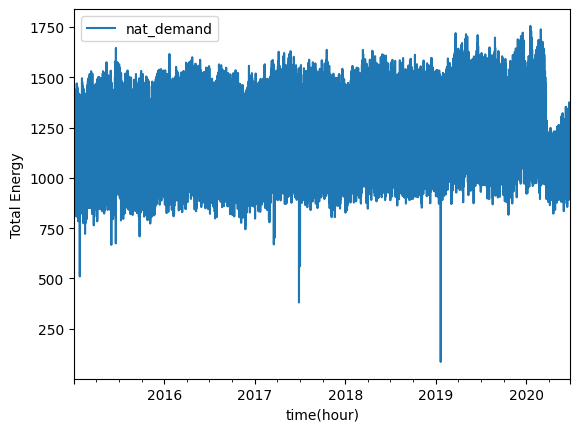

In [12]:
df[['nat_demand']]['2015-01-03':'2020-06-27'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Total Energy')

Let's zoom into the data and mark every Saturday by vertical dotted lines.

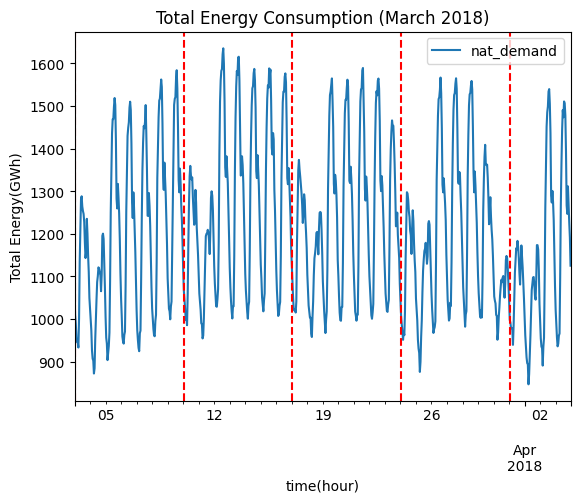

In [13]:

df[['nat_demand' ]]['2018-03-03': '2018-04-03'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Total Energy(GWh)')
plt.title('Total Energy Consumption (March 2018)')

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Saturday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

### Computing Autocorrelation for the 'nat_demand' Column

---



Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

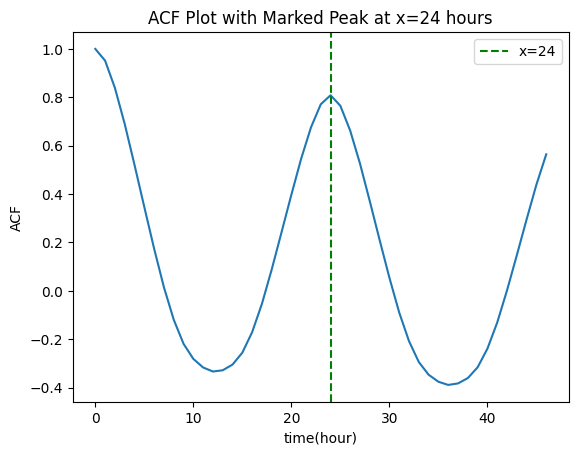

In [14]:

plt.plot(acf(df['nat_demand']))
plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

Text(0, 0.5, 'temperature')

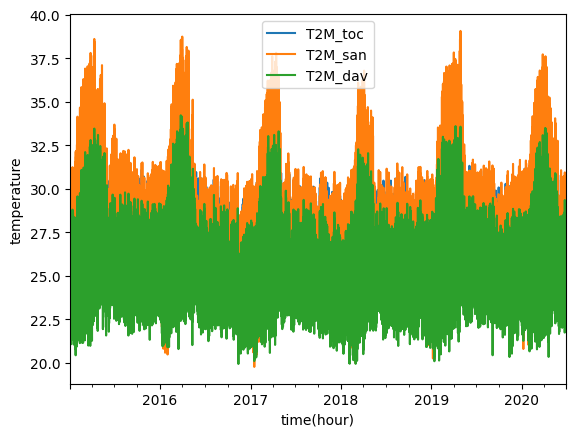

In [15]:
df[['T2M_toc', 'T2M_san', 'T2M_dav']]['2015-01-03':'2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('temperature')

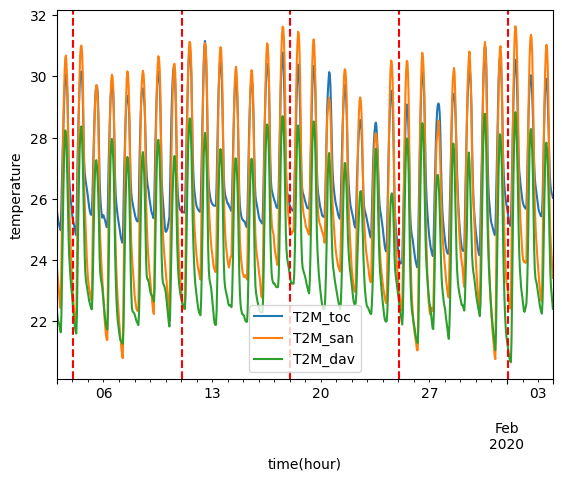

In [16]:
df[['T2M_toc', 'T2M_san', 'T2M_dav']]['2020-01-03':'2020-02-03'].plot()
plt.xlabel('time(hour)')
plt.ylabel('temperature')
# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Saturday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

### Computing Autocorrelation

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

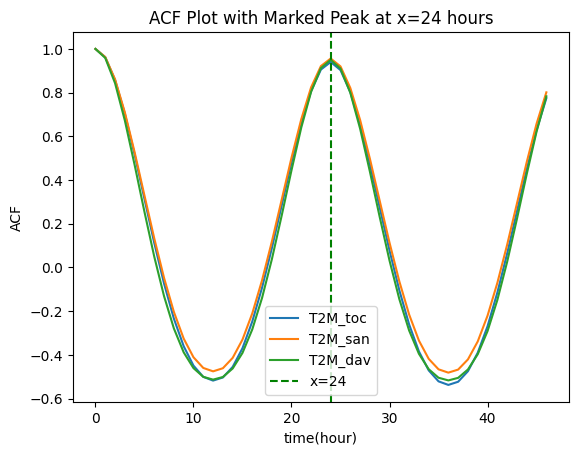

In [17]:
plt.plot(acf(df['T2M_toc']), label='T2M_toc')
plt.plot(acf(df['T2M_san']), label='T2M_san')
plt.plot(acf(df['T2M_dav']), label='T2M_dav')

plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

## Solar Power Production:

Text(0, 0.5, 'Wind Speed')

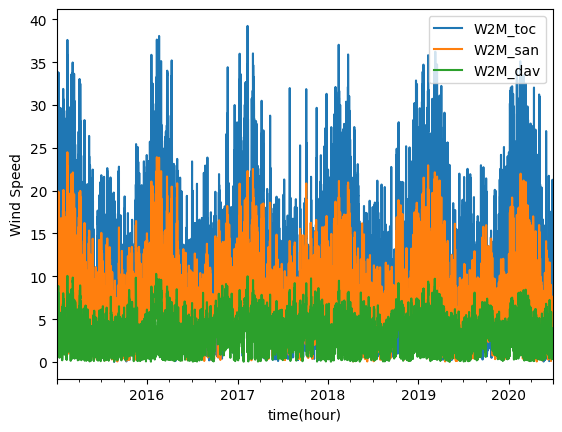

In [19]:
df[['W2M_toc', 'W2M_san','W2M_dav']]['2015-01-03':'2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Wind Speed')

During January and February, solar power generation reaches its lowest levels. To observe daily trends, we will examine a month's worth of data.

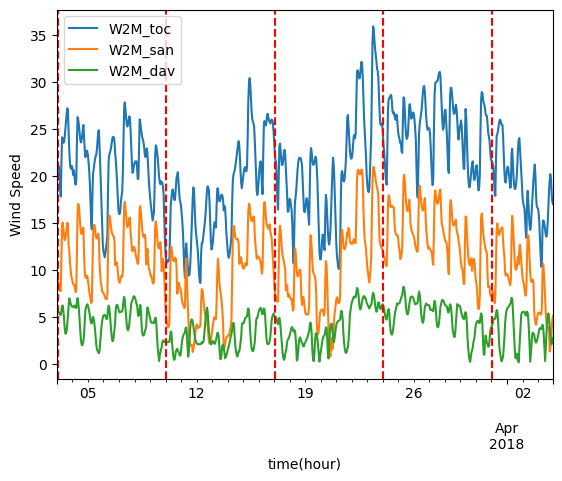

In [20]:
df[['W2M_toc', 'W2M_san','W2M_dav']]['2018-03-03': '2018-04-03'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Wind Speed')
# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Saturday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

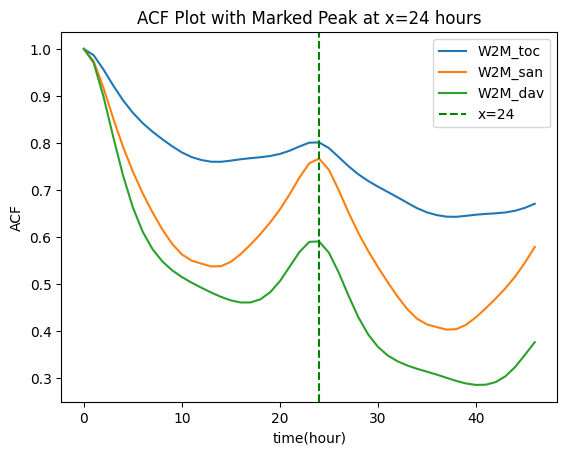

In [21]:

plt.plot(acf(df['W2M_toc']), label='W2M_toc')
plt.plot(acf(df['W2M_san']), label='W2M_san')
plt.plot(acf(df['W2M_dav']), label='W2M_dav')

plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

## Pie chart

In [11]:

def pie_chart(start, end, df):
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()

    absolute_aggregated_data.drop(['nat_demand'], inplace=True)
    # Plotting the pie chart
    # absolute_aggregated_data.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), title='Energy Distribution for the Selected Period')

    # Explode smaller slices to make them more visible and separate labels
    explode_values = [0.1 if value < 1e6 else 0 for value in absolute_aggregated_data]

    # Plotting the adjusted pie chart
    plt.figure(figsize=(12, 12))  # Increased figure size for better clarity
    absolute_aggregated_data.plot(kind='pie', autopct='%1.1f%%',
                                  title='Distribution',
                                  explode=explode_values)

# Filter data for a specific time period (update this to your desired dates)


### Pie Chart Year 2018

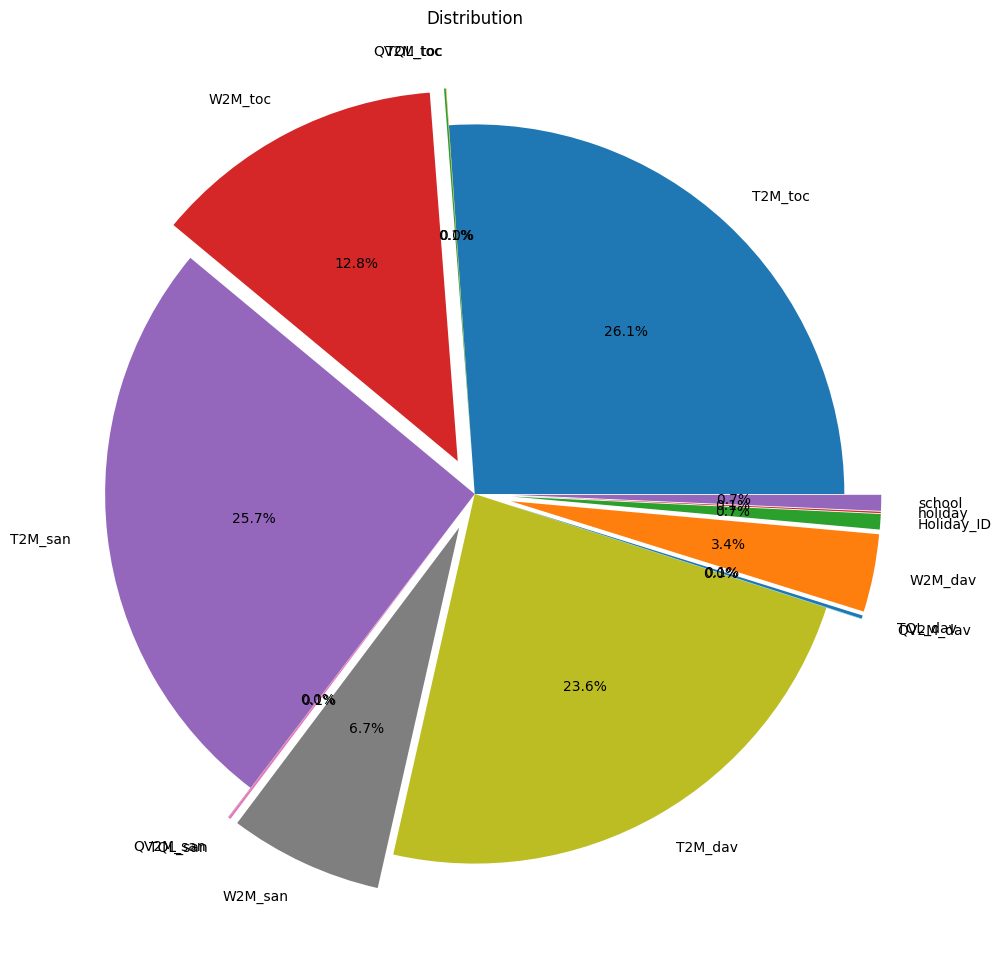

In [12]:
start_date = '2015-01-03'
end_date = '2020-06-27'
pie_chart(start_date, end_date, df)

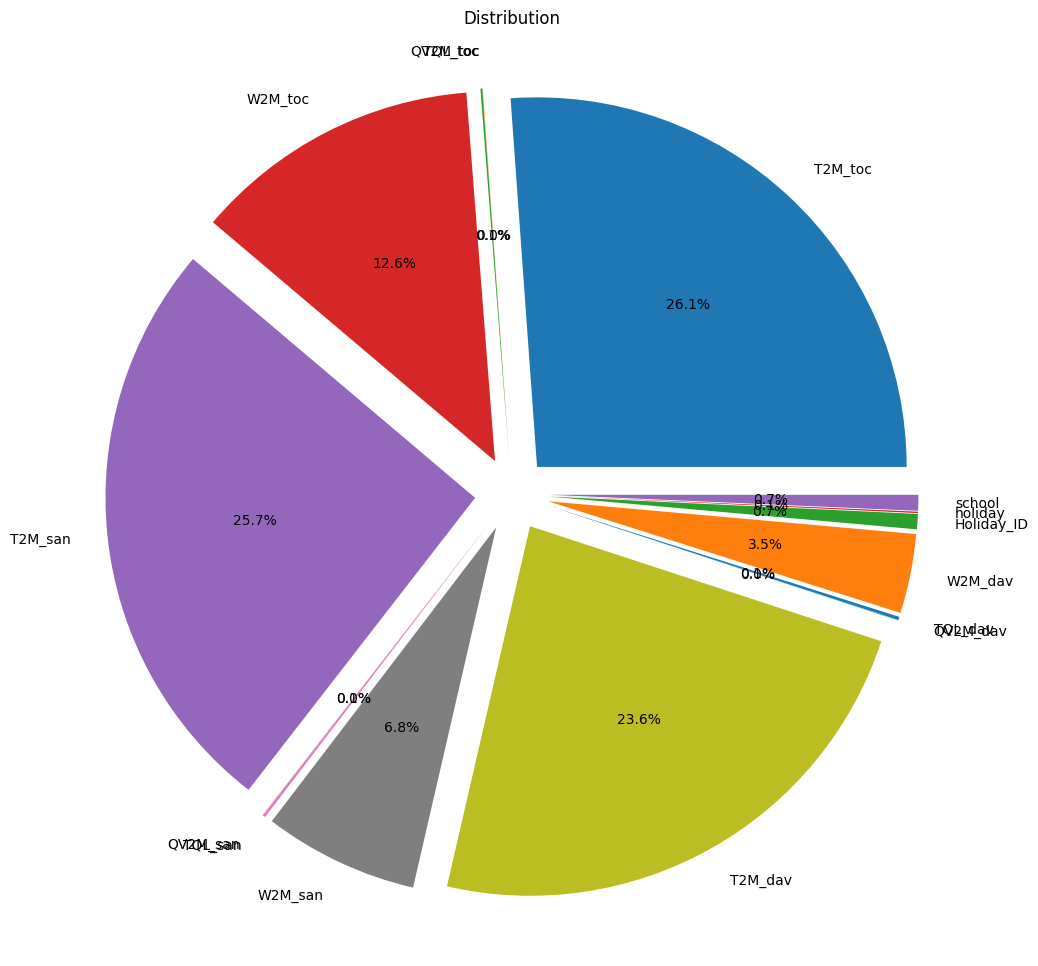

In [13]:
start_date = '2015-01-03'
end_date = '2020-06-27'
pie_chart(start_date, end_date, df)

In [30]:
def bar_chart(start_date, end_date, df):
    # Create a mask for the selected date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()

    # Dropping columns 'GrossCon' and 'NetCon'
    absolute_aggregated_data.drop(['nat_demand', 'holiday', 'Holiday_ID','QV2M_toc' , 'QV2M_san', 'QV2M_dav'], inplace=True)

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    absolute_aggregated_data.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(' net demand)')  # Add title
    plt.xlabel('types')  # Add x-label
    plt.ylabel('total')  # Add y-label
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


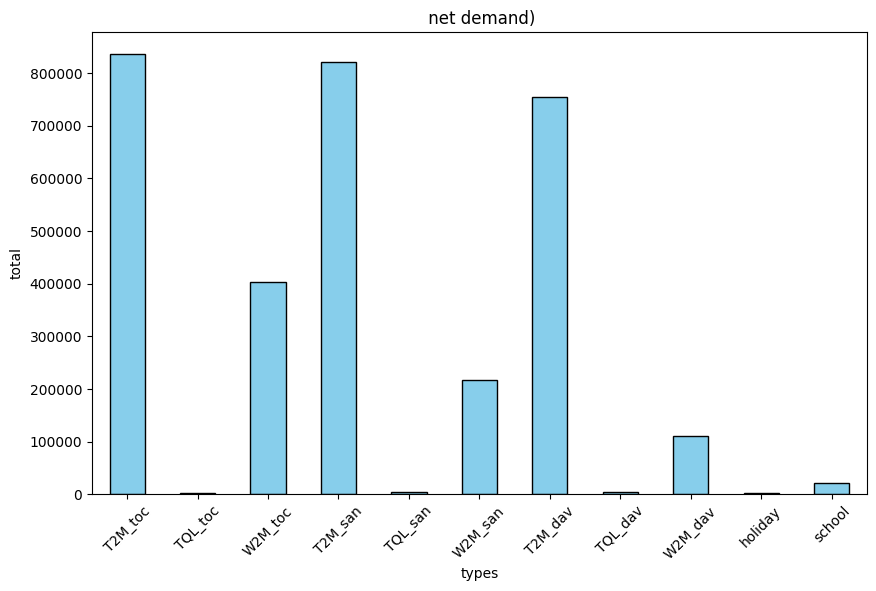

In [31]:
bar_chart(start_date, end_date, df)

The graph presented above illustrates the contributions of various energy segments.

In [32]:


def multi_year_bar_chart(years, df):
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    # Adjust the width of the bars and the spacing between them
    bar_width = 0.2
    spacing = 0.05
    total_width = bar_width * len(years) + spacing * (len(years) - 1)

    # Colors for different years
    colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple', 'crimson', 'deepskyblue', 'gold', 'mediumorchid']


    for i, year in enumerate(years):
        # Creating a mask for each year
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        mask = (df.index >= start_date) & (df.index <= end_date)
        filtered_df = df.loc[mask]

        # Aggregate and process the data
        aggregated_data = filtered_df.sum()
        absolute_aggregated_data = aggregated_data.abs()
        absolute_aggregated_data.drop(['nat_demand', 'holiday', 'Holiday_ID','QV2M_toc' , 'QV2M_san', 'QV2M_dav'], inplace=True)

        # Calculate the offset for each bar
        offset = (np.arange(len(absolute_aggregated_data)) * total_width) + (i * bar_width)

        # Plotting the bars for each year
        plt.bar(x=offset,
                height=absolute_aggregated_data,
                width=bar_width,
                color=colors[i % len(colors)],
                edgecolor='black',
                label=f'{year}')

    # Adjust the x-ticks to be in the center of the group of bars
    plt.xticks(ticks=np.arange(len(absolute_aggregated_data)) * total_width + bar_width,
               labels=absolute_aggregated_data.index,
               rotation=45)

    plt.title(' Distribution by Year')
    plt.xlabel('types')
    plt.ylabel(' total')
    plt.legend(title='Year')
    plt.show()

# Sample call to the function with the DataFrame
# Replace this with your actual DataFrame
# multi_year_bar_chart([2017, 2018, 2019], df)



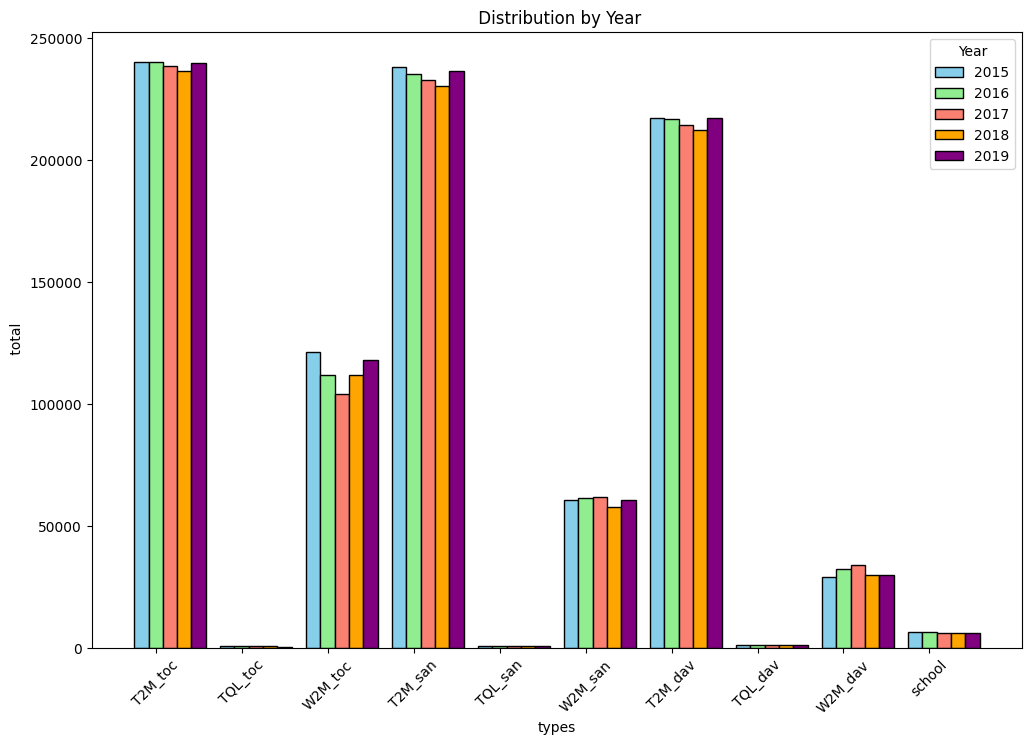

In [33]:
multi_year_bar_chart(range(2015, 2020), df)

# Modeling:


In [34]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [35]:
adf_test(df['nat_demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -20.961750
p-value                     0.000000
# lags used                57.000000
# observations          47990.000000
critical value (1%)        -3.430486
critical value (5%)        -2.861600
critical value (10%)       -2.566802
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary



### Data Splitting into Training and Testing Sets
To prepare our data for modeling and evaluation, we need to split it into training and testing sets. This allows us to train our model on one portion of the data and assess its performance on another. Below is the code to obtain information about the maximum and minimum timestamps in our dataset:

In [36]:
# Printing the maximum timestamp in the dataset
print(df.index.max())

# Printing the minimum timestamp in the dataset
print(df.index.min())


2020-06-27 00:00:00
2015-01-03 01:00:00


Selecting the following date as the dividing point between training and testing data:

In [38]:
dev_date_str = '2017-12-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')
df.index = df.index.tz_localize('UTC')
train_data = df[:dev_date]
test_data = df[dev_date:]

## First Model: Exponential Smoothing
### Model Evaluation: Performance Assessment on Test Set


In [39]:
fitted_model = ExponentialSmoothing(train_data['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Model Evaluation on Test Dataset



In [40]:
# Set the number of days for which the prediction is to be made
number_of_days = 120

# Calculate the total number of hours to predict based on the number of days
number_of_hours_to_predict = number_of_days * 24

# Calculate the end date for the prediction by adding the total hours to the development date (dev_date)
end_date = dev_date + timedelta(hours=number_of_hours_to_predict - 1)

# Extract the actual Gross Consumption data from the test dataset for the specified period
y = test_data['nat_demand'][dev_date:end_date]

# Use the fitted model to forecast the values for the specified number of hours and rename the output series to 'HW_Forecast'
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')


### Visual Comparison of Train, Test, and Predicted Values
The following code snippet is designed to visually compare the Gross Consumption values across the training data, test data, and the model's predictions:

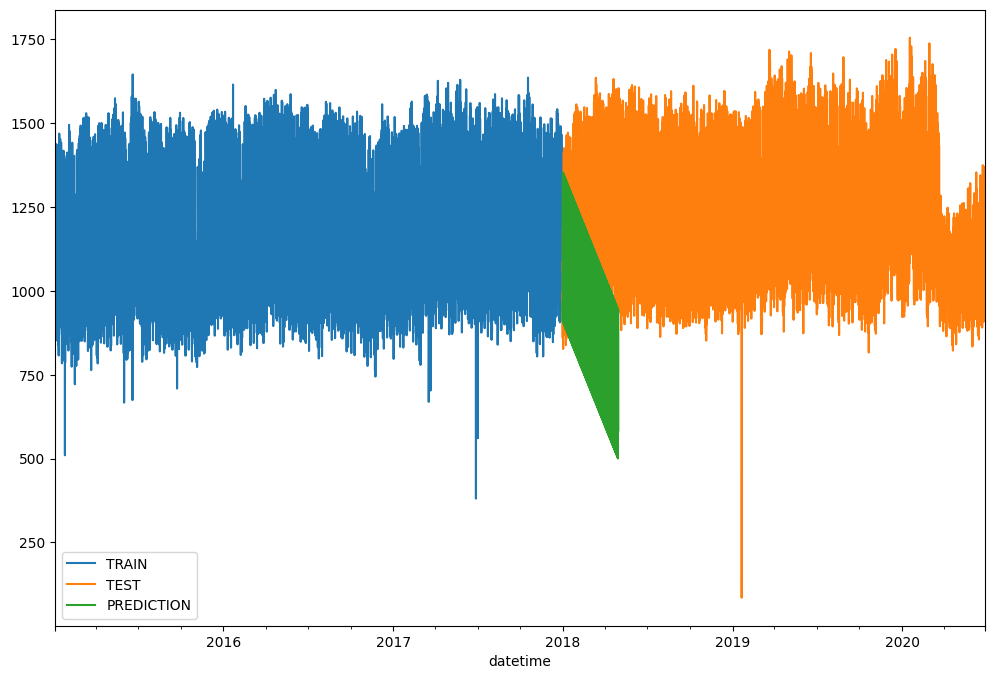

In [41]:
# Plotting the Gross Consumption from the training data
train_data['nat_demand'].plot(legend=True, label='TRAIN')

# Plotting the Gross Consumption from the test data
test_data['nat_demand'].plot(legend=True, label='TEST', figsize=(12,8))

# Plotting the predicted Gross Consumption values
test_predictions.plot(legend=True, label='PREDICTION');


To get a clearer comparison, let's zoom in on the plot:

<Axes: xlabel='datetime'>

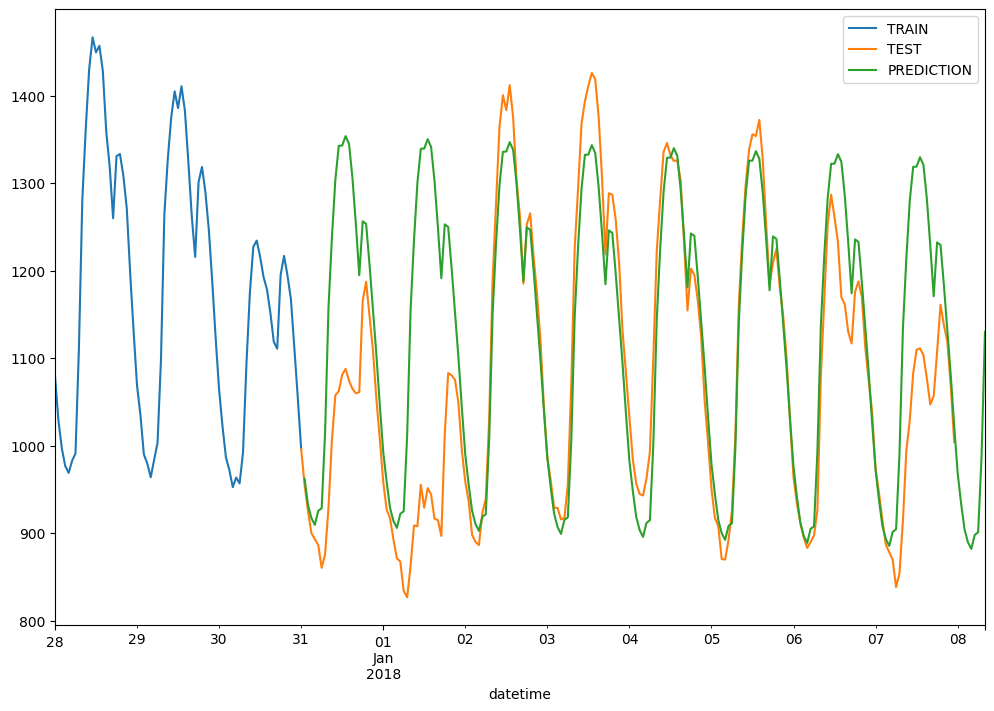

In [42]:
# Plotting the training data
train_data['nat_demand']['2017-12-28':].plot(legend=True, label='TRAIN')

# Plotting the testing data
test_data['nat_demand'][:'2018-01-07'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the predictions (first 200 points)
test_predictions[:200].plot(legend=True, label='PREDICTION')


### Evaluation Metrics


#### Mean Absolute Error (MAE):



In [43]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, test_predictions)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 275.1981285461904


#### Mean Squared Error (MSE):


In [44]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, test_predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 102430.67639839477


#### Root Mean Squared Error (RMSE):


In [45]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 320.04792828324133


The model is performing poorly. It implies that the model's predictions are not accurately capturing the underlying patterns in the data.

## Forecasting into the Future
### Exponential Smoothing

In [46]:
final_model = ExponentialSmoothing(df['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='datetime'>

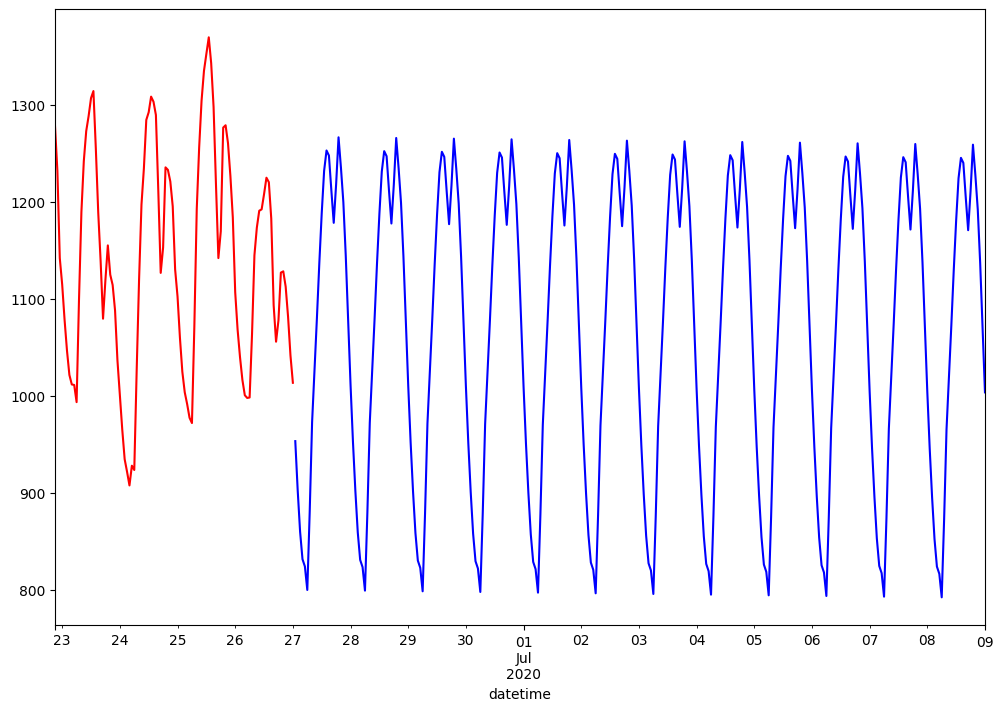

In [47]:
# Setting the number of days for the forecast
day_forecast = 12
hours_forecast = day_forecast * 24

# Generating forecast predictions
forecast_predictions = final_model.forecast(hours_forecast)

# Plotting the last 100 data points in red and the forecast in blue
df['nat_demand'][-100:].plot(figsize=(12, 8), color='red')
forecast_predictions.plot(color='blue')

## Autoregression (AR) Model


In [48]:
# Importing the Autoregression model from statsmodels library
from statsmodels.tsa.ar_model import AutoReg,ARResults

In [49]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [50]:
model = AutoReg(train_data['nat_demand'], lags=1)

In [51]:
ARfit = model.fit()

In [52]:
ARfit.params

const            58.996727
nat_demand.L1     0.949018
dtype: float64

In [53]:
# This is the general format for obtaining predictions
start=len(train_data['nat_demand'])
end=len(train_data['nat_demand'])+len(test_data['nat_demand'])-1
predictions1 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='datetime'>

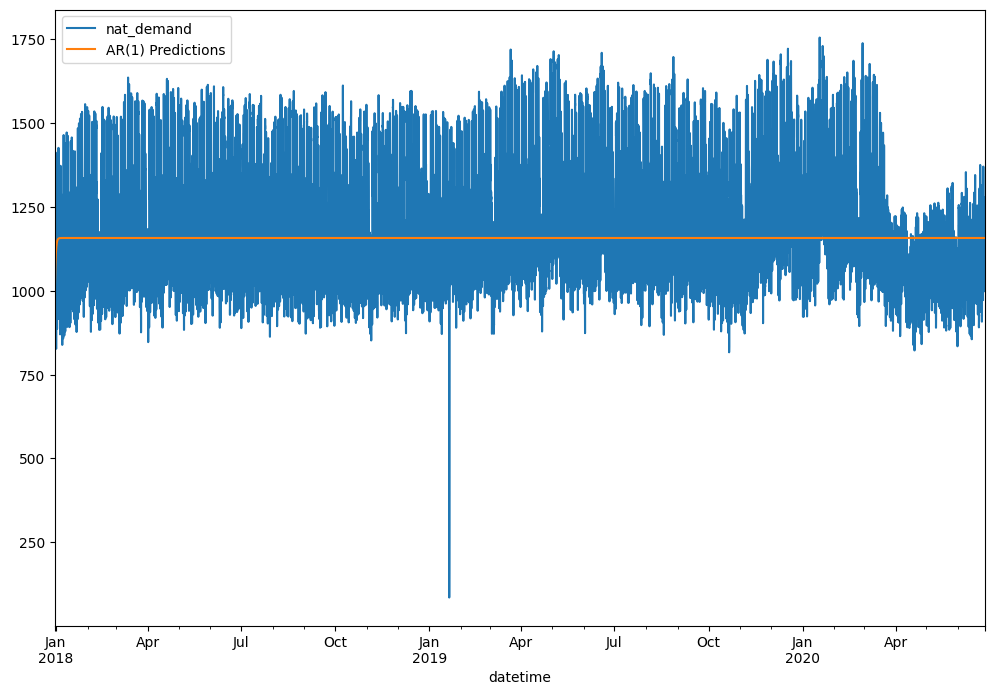

In [54]:
test_data['nat_demand'].plot(figsize=(12, 8), legend=True)
predictions1.plot(figsize=(12, 8), legend=True)

In [55]:

mae = mean_absolute_error(test_data['nat_demand'], predictions1)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 159.92319572435957


In [56]:
mse = mean_squared_error(test_data['nat_demand'], predictions1)
print("Mean Squared Error:", mse)


Mean Squared Error: 38211.641427252376


In [57]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 195.47798195002008


## Automated ARIMA Model Selection with `pmdarima`

In [58]:
# Importing the `auto_arima` function from `pmdarima` library
!pip install pmdarima
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.4 MB/s eta 0:00:00


# Automated ARIMA Model Selection and Summary

In [59]:
# Using auto_arima to automatically select the best ARIMA model for 'GrossCon' time series data

# Data input: 'GrossCon' time series data (first 1000 data points)
stepwise_fit = auto_arima(df['nat_demand'][:500],

                          # Starting values for ARIMA orders
                          start_p=0,  # Autoregressive order (p)
                          start_q=0,  # Moving average order (q)

                          # Maximum allowable ARIMA orders
                          max_p=3,  # Maximum autoregressive order (p)
                          max_q=3,  # Maximum moving average order (q)

                          # Seasonality information (24-hour seasonality)
                          m=24,  # Number of time steps in a seasonal cycle

                          # Enable seasonal decomposition
                          seasonal=True,

                          # Differencing order (None implies automatic differencing)
                          d=None,

                          # Display progress information during model search
                          trace=True,

                          # Behavior when an order doesn't work (ignore errors)
                          error_action='ignore',

                          # Suppress convergence warnings
                          suppress_warnings=True,

                          # Use the stepwise search approach for efficiency
                          stepwise=True)


stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=6259.356, Time=19.33 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=6621.700, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=24.59 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=5797.247, Time=13.97 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=8434.955, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=6005.168, Time=4.71 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=5797.939, Time=11.27 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=5675.693, Time=23.57 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=5679.311, Time=38.64 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=6242.280, Time=11.52 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=4911.569, Time=28.06 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=5009.431, Time=4.61 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=4726.761, Time=25.11 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=4699.180, Time=5.46 sec
 ARIMA(1,0,1)(1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  500
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 24)   Log Likelihood               -2335.539
Date:                              Mon, 05 Aug 2024   AIC                           4685.079
Time:                                      19:12:36   BIC                           4714.581
Sample:                                  01-03-2015   HQIC                          4696.655
                                       - 01-23-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.5657      1.939      3.386      0.001       2.765      10.367
ar.L1          0.8892      0.017     51.905      0.000       0.856       0.923
ma.L1          0.4751      0.038     12.659      0.000       0.402       0.549
ma.L2          0.2485      0.042      5.928      0.000       0.166       0.331
ar.S.L24       0.9441      0.012     76.680      0.000       0.920       0.968
ma.S.L24      -0.6480      0.039    -16.732      0.000      -0.724      -0.572
sigma2       599.8471     29.054     20.646      0.000     542.902     656.792
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):                95.68
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(1,0,2)(1,0,2)[24] is the best model.

In [63]:
# Import the necessary library
import statsmodels.api as sm

# Create the ARIMA model with the selected parameters
model = sm.tsa.ARIMA(train_data['nat_demand'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24), enforce_stationarity=False)

# Fit the ARIMA model to the data
model_fit = model.fit()

In [80]:
your_desired_number_of_steps = 24 * 30

# Make future predictions
forecasted_values = model_fit.forecast(steps=your_desired_number_of_steps)

<Axes: xlabel='datetime'>

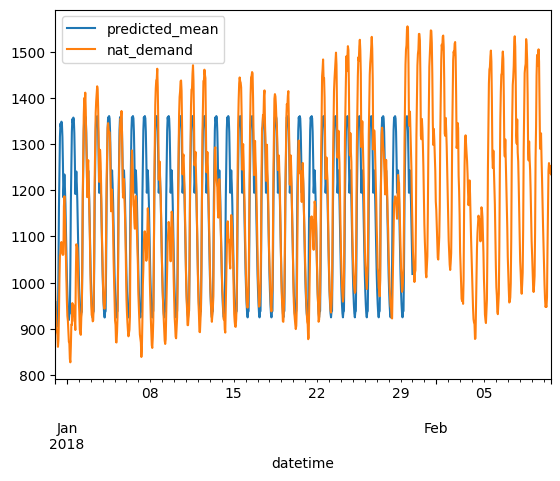

In [81]:
forecasted_values.plot(legend=True)
test_data['nat_demand'][:1000].plot(legend=True)

In [82]:
mae = mean_absolute_error(test_data['nat_demand'][:your_desired_number_of_steps], forecasted_values)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 85.31908958958755


In [83]:
mse = mean_squared_error(test_data['nat_demand'][:your_desired_number_of_steps], forecasted_values)
print("Mean Squared Error:", mse)

Mean Squared Error: 13866.546840593757


In [84]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 117.75630276377463


model exhibits a lower level of error than previous one, indicating its slightly better. but still inadequant as an effective predictive model.

## Seasonal Autoregressive Integrated Moving Average (SARIMA) Model


### Using the seasonal decomposed data as exogenic parameter in SARIMA.

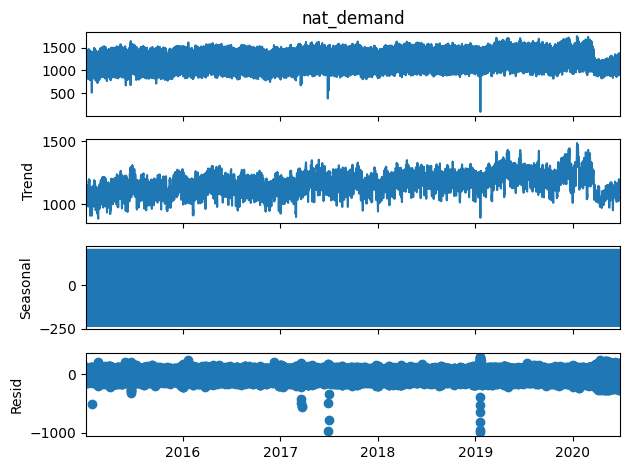

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['nat_demand'], model='additive')  # model='add' also works
result.plot();

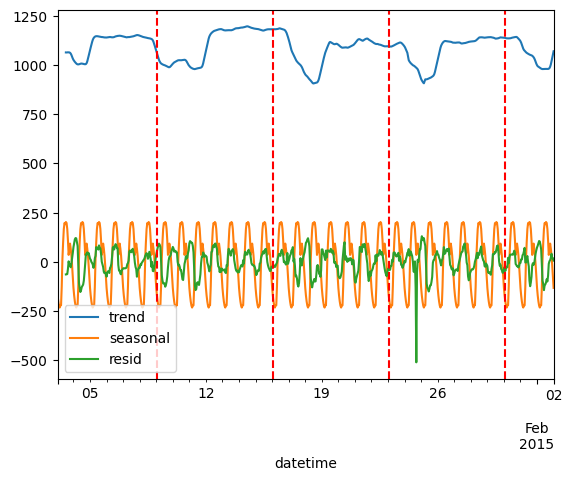

In [86]:
n_days = 30
n = 24 * n_days
# To plot the first n points of the trend component
result.trend[:n].plot(legend=True);

# To plot the first n points of the seasonal component
result.seasonal[:n].plot(legend=True);

# To plot the first n points of the residual component
result.resid[:n].plot(legend=True);

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

<Axes: xlabel='datetime'>

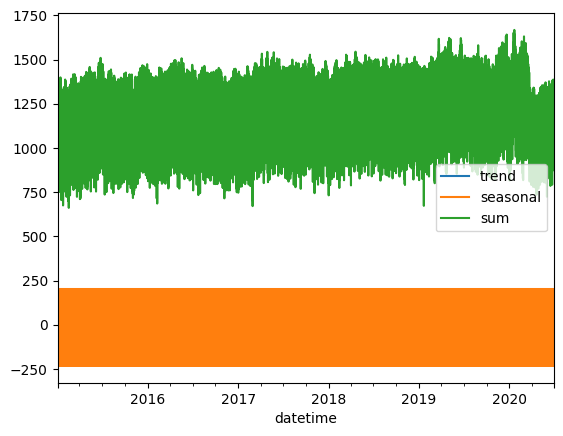

In [87]:
decomp_data = {}
decomp_data['trend'] = result.trend
decomp_data['seasonal'] = result.seasonal
df_decom_data = pd.DataFrame(decomp_data)
df_decom_data['sum'] = df_decom_data['trend'] + df_decom_data['seasonal']
df_decom_data.plot()

In [88]:
df_decom_data.head()

,trend,seasonal,sum
datetime,,,
2015-01-03 01:00:00+00:00,NaN,-171.887459,NaN
2015-01-03 02:00:00+00:00,NaN,-201.678198,NaN
2015-01-03 03:00:00+00:00,NaN,-223.106475,NaN
2015-01-03 04:00:00+00:00,NaN,-232.980741,NaN
2015-01-03 05:00:00+00:00,NaN,-220.058009,NaN


Creating train and test data sets:

In [89]:
dev_date_str = '2017-12-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')
train_data_exo = df[:dev_date]
test_data_exo = df[dev_date:]

df_decom_data_train = df_decom_data[:dev_date]

<Axes: xlabel='datetime'>

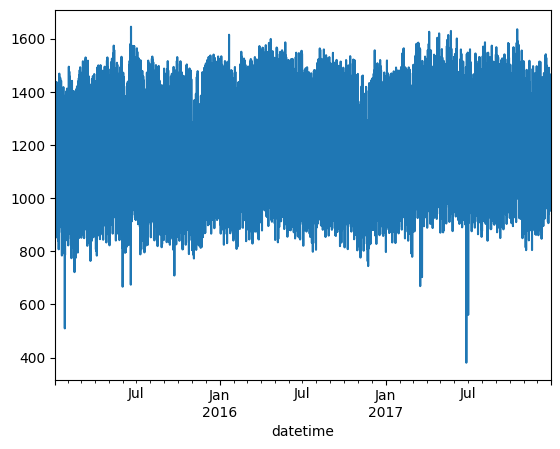

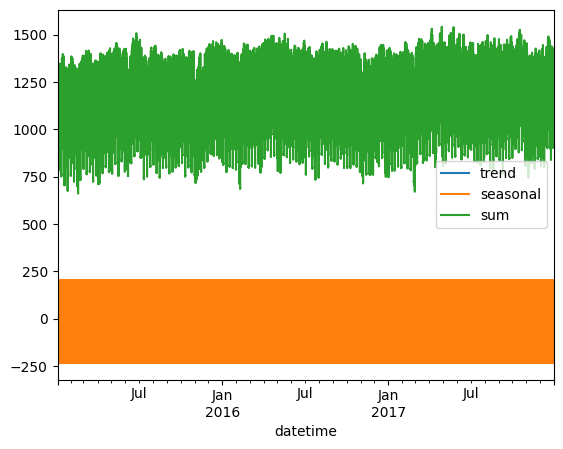

In [90]:
ind = 100000

train_data_exo['nat_demand'][:ind].plot()
df_decom_data_train[:ind].plot()

Fitting the model to the train data set:

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

index = - 200

model = SARIMAX(train_data_exo['nat_demand'][index:],
                exog=df_decom_data_train[index:],
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         nat_demand   No. Observations:                  200
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                -901.774
Date:                            Mon, 05 Aug 2024   AIC                           1819.548
Time:                                    19:30:08   BIC                           1845.934
Sample:                                12-22-2017   HQIC                          1830.226
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.3813      0.028     13.521      0.000       0.326       0.437
seasonal       0.2412      0.037      6.452      0.000       0.168       0.315
sum            0.6226      0.014     44.145      0.000       0.595       0.650
ar.L1          0.8697      0.042     20.907      0.000       0.788       0.951
ma.L1          0.2899      0.066      4.396      0.000       0.161       0.419
ar.S.L24       0.3535      0.166      2.128      0.033       0.028       0.679
ma.S.L24       0.0585      0.193      0.303      0.762      -0.320       0.437
sigma2       468.0636     38.367     12.200      0.000     392.867     543.261
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):                15.73
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.18
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+18. Standard errors may be unstable.
"""

Preparing the exog_forcast data for prediction purposes:

In [93]:
print({exog_forecast.shape})

{(21745, 3)}


In [94]:
print(n_hours_to_predict)

21817


they dont have the same length

In [98]:
exog_forecast = exog_forecast.head(n_hours_to_predict)
forecast = exog_forecast.shape[0]

In [107]:
start_hour = train_data_exo.index.max()
n_hours_to_predict = test_data_exo.shape[0]

end_hour = start_hour + pd.Timedelta(hours=forecast)

delt = end_hour - start_hour
# start_hour = test_data_exo.index.min()
# end_hour = test_data_exo.index.max()


# to find the exog_forecast data we go back n years in data and pick the history
n_years_back = 3
start_hour_exo_test = start_hour - pd.DateOffset(years=n_years_back)
exog_forecast = df_decom_data_train[start_hour_exo_test: start_hour_exo_test + delt]

new_end = start_hour + pd.Timedelta(hours=exog_forecast.shape[0])
exog_forecast = exog_forecast.fillna(method='ffill')


In [110]:
# Check for infinite values and NaNs in your exog_forecast DataFrame
print(exog_forecast.isnull().sum())  # Check for missing values (NaNs)
print(np.isinf(exog_forecast).sum()) # Check for infinite values

# If there are NaNs or inf, handle them appropriately.
# For example, you can fill NaNs with a reasonable value or use interpolation:
exog_forecast = exog_forecast.fillna(method='ffill')  # Forward fill missing values
exog_forecast = exog_forecast.replace([np.inf, -np.inf], np.nan).fillna(method='ffill') # Replace infinite values with NaNs and then forward fill

trend       12
seasonal     0
sum         12
dtype: int64
trend       0
seasonal    0
sum         0
dtype: int64


In [119]:
print("Missing values in each column:")
print(exog_forecast.isnull().sum())

Missing values in each column:
trend       12
seasonal     0
sum         12
dtype: int64


In [120]:
exog_filled = exog_forecast.fillna(0)

# Verify that there are no more missing values
print("Missing values after filling with 0:")
print(exog_filled.isnull().sum())

Missing values after filling with 0:
trend       0
seasonal    0
sum         0
dtype: int64


In [121]:
predictions = results.predict(start=start_hour,
                              end=new_end,
                              exog=exog_filled).rename('SARIMAX(1, 0, 1)(1, 0, 1, 24) Predictions')

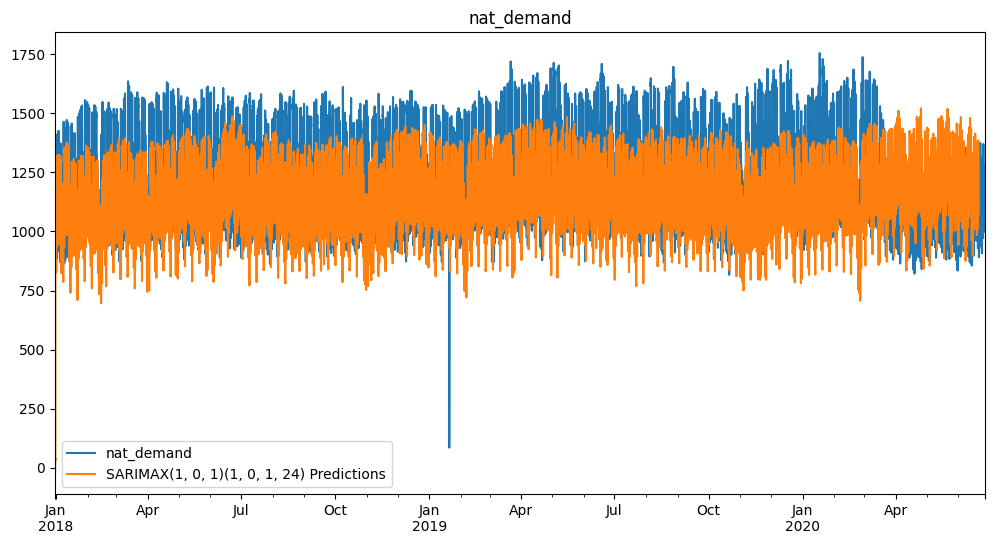

In [122]:
# Plot predictions against known values
title = 'nat_demand'
ylabel=''
xlabel=''

ax = test_data_exo['nat_demand'][:100000].plot(legend=True,figsize=(12,6),title=title)
predictions[:100000].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

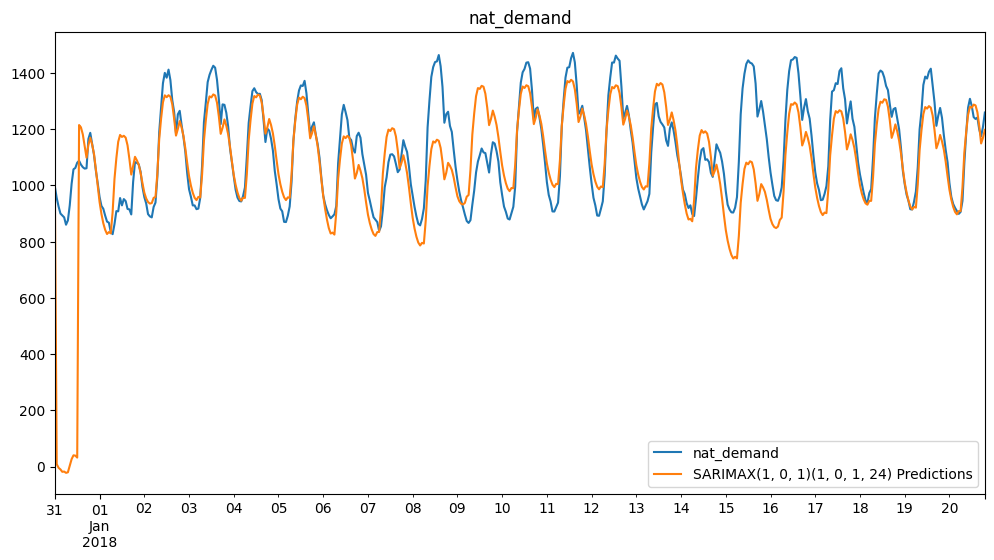

In [123]:
ax = test_data_exo['nat_demand'][:500].plot(legend=True,figsize=(12,6),title=title)

predictions[:500].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [127]:
y = test_data_exo['nat_demand'].iloc[:len(predictions[:-1])]

mae = mean_absolute_error(y, predictions[:-1])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 117.40205317436875


In [128]:
mse = mean_squared_error(y, predictions[:-1])
print("Mean Squared Error:", mse)

Mean Squared Error: 23497.466726297112


In [129]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
df.shape

Root Mean Squared Error: 153.2888343171058


(48048, 16)

### Apply on the above method on all of the data:

In [145]:



ind_start = '2019-07-26 10:00:00+00:00'
ind_end = '2019-07-26 23:00:00+00:00'


y = df_decom_data.ffill().bfill()

# Slice the filled exogenous data
z = y.loc[ind_start:ind_end]



In [146]:

model = SARIMAX(df['nat_demand'][ind_start:ind_end],
                exog = z,
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         nat_demand   No. Observations:                   14
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                 -62.536
Date:                            Mon, 05 Aug 2024   AIC                            141.071
Time:                                    20:06:45   BIC                            146.184
Sample:                                07-26-2019   HQIC                           140.598
                                     - 07-26-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.3724      0.090      4.136      0.000       0.196       0.549
seasonal       0.2755      0.151      1.822      0.068      -0.021       0.572
sum            0.6243      0.062     10.123      0.000       0.503       0.745
ar.L1          0.3833      0.337      1.138      0.255      -0.277       1.043
ma.L1          1.8768      1.921      0.977      0.329      -1.889       5.643
ar.S.L24       0.0283      8.649      0.003      0.997     -16.924      16.980
ma.S.L24       0.0281      8.635      0.003      0.997     -16.897      16.953
sigma2       118.1329      0.650    181.773      0.000     116.859     119.407
===================================================================================
Ljung-Box (L1) (Q):                   2.51   Jarque-Bera (JB):                 1.69
Prob(Q):                              0.11   Prob(JB):                         0.43
Heteroskedasticity (H):               0.26   Skew:                             0.80
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+18. Standard errors may be unstable.
"""

### Predicting the future:

In [147]:
start_hour = df.index.max()

# Define the prediction horizon
n_years_to_predict = 0
n_months_to_predict = 1
n_day_to_predict = 29
end_hour = start_hour + pd.DateOffset(years=n_years_to_predict, months=n_months_to_predict, days=n_day_to_predict)

print(start_hour, end_hour)
delt = end_hour - start_hour

print(delt)



2020-06-27 00:00:00+00:00 2020-08-25 00:00:00+00:00
59 days 00:00:00


In [154]:
len = len(pd.date_range(start_hour, end_hour, freq="H"))
print(len)


1417
